# This script tests harvest effort across both predator and prey 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

## Pred - Prey Model Functions

In [7]:
def dNdt(H, P, parameters_dict):
    #Unpacking herbivore parameters:
    r_H = parameters_dict['r_H'] # growth rate of herbivores
    K_H = parameters_dict['K_H'] # carrying capacity of herbivores
    theta_H = parameters_dict['theta_H'] # immigration of herbivores
    c = parameters_dict['c'] # addition to predator from prey
    d = parameters_dict['d'] # value of H when predation half its max value
    q_H = parameters_dict['q_H'] # proportionality constant for herbivore harvest
    E_H = parameters_dict['E_H'] # Effort for herbivore harvest
    #Unpacking predator parameters:
    r_P = parameters_dict['r_P'] # growth rate of predator 
    K_P = parameters_dict['K_P'] # carrying capactiy of predators 
    b = parameters_dict['b'] # mortality to prey from predator
    theta_P = parameters_dict['theta_P'] # immigration of predators  
    q_P = parameters_dict['q_P'] # proportionality constant for predators harvest
    E_P = parameters_dict['E_P'] # Effort for predator harvest
    
    #Calculate the derivative 
    dH = r_H*H*(1-H/K_H) - (c*H*P)/(d+H) + theta_H - q_H*E_H*H
    dP = r_P*P*(1-P/K_P) + (b*H*P)/(d+H) + theta_P - q_P*E_P*P
    
    return dH, dP

In [8]:
# Function: numerical solver, 2nd order RK 

def RK2(H, P, parameters_dict):
    H_init = H
    P_init = P 
    
    dH1, dP1 = dNdt(H,P,parameters_dict)
    
    H1 = H + 0.5*dH1
    P1 = P + 0.5*dP1
    
    dH2, dP2 = dNdt(H1,P1,parameters_dict)
    
    dH_ave = (dH1+dH2)/2 
    dP_ave = (dP1+dP2)/2 
    
    H = H_init + dH_ave
    P = P_init + dP_ave
    
    #Calculate harvest 
    q_H = parameters_dict['q_H'] #proportionality constant for herbivore harvest 
    E_H = parameters_dict['E_H'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    return H, P, herbivore_harvest, predator_harvest

In [9]:
# Function to run the model 

def run_model(INIT_H, INIT_P, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    
    H_array[0] = INIT_H #Starting biomass of herbivore 
    P_array[0] = INIT_P #Starting biomass of predator 
    H_harvest_array[0] = 0
    P_harvest_array[0] = 0
    
    for i in np.arange(0,numyears):
        H_array[i+1], P_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1] \
            = RK2(H_array[i], P_array[i], parameters_dict)
        i = i+1
    
    return H_array, P_array, H_harvest_array, P_harvest_array

## Run model and generate fishing heatmap

In [10]:
#Run model simulation

numyears = 100 # number of years to run simulation 

#Herbivore parameters:
r_H = 0.5 # growth rate of herbivores
K_H = 5000 # carrying capacity of herbivores
theta_H = 50 # immigration of herbivores
c = 0.4 #additional mortality of H 
d = 500 # value of H when predation half its max value 
q_H = 1. # proportionality constant for herbivore harvest 
E_H = 0.0 # Effort for herbivore harvest (0.05 = limit cycle, 0.2 = stable state)
#Predator parameters:
r_P = 0.3 # growth rate of predator 
K_P = 2000 # carrying capactiy of predators
b = 0.4 # additional growth of P due to H
theta_P = 0 # immigration of predators 
q_P = 1. # proportionality constant for predator harvest 
E_P = 0.0 # Effort for predator harvest

parameters_dict = {'numyears': numyears, 
                  'r_H': r_H, 
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H, 
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  }

H0 = 1000
P0 = 100

H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)

In [11]:
size = 50
heatmap_H = np.zeros((size, size))
heatmap_P = np.zeros((size, size))
heatmap_T = np.zeros((size, size))
E_H_array = np.linspace(0, 1.0, size)
E_P_array = np.linspace(0, 1.0, size)

#Loop through E_P and E_H values from 0-1 
for i in np.arange(0, size):
    for j in np.arange(0, size):
        E_H = E_H_array[i]
        E_P = E_P_array[j] 
        parameters_dict['E_H'] = E_H 
        parameters_dict['E_P'] = E_P
        H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)
        H_last = np.mean(H_array[-25:-1])
        P_last = np.mean(P_array[-25:-1])
        T_last = np.mean(np.add(H_array[-25:-1], P_array[-25:-1]))
        heatmap_T[i,j] = T_last
        heatmap_H[i,j] = H_last
        heatmap_P[i,j] = P_last
        j+=1
    i+=1

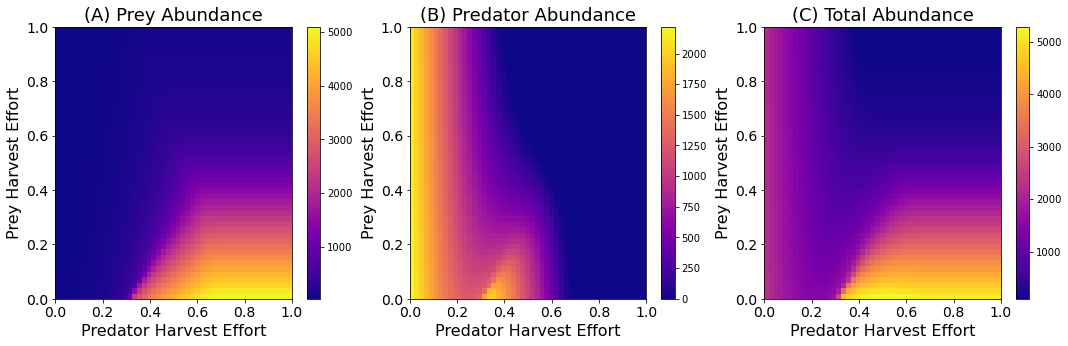

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize = (18,5))

im = ax0.pcolormesh(E_P_array, E_H_array, heatmap_H, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax0, orientation="vertical", pad = 0.05)
ax0.set_title(label="(A) Prey Abundance", fontsize=18)
ax0.set_ylabel("Prey Harvest Effort", fontsize=16)
ax0.set_xlabel("Predator Harvest Effort", fontsize=16)
ax0.tick_params(labelsize=14)

im = ax1.pcolormesh(E_P_array, E_H_array, heatmap_P, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax1, orientation="vertical", pad = 0.05)
ax1.set_title(label="(B) Predator Abundance", fontsize=18)
ax1.set_ylabel("Prey Harvest Effort", fontsize=16)
ax1.set_xlabel("Predator Harvest Effort", fontsize=16)
ax1.tick_params(labelsize=14)

im = ax2.pcolormesh(E_H_array, E_P_array, heatmap_T, cmap=plt.cm.get_cmap('plasma'),shading='auto')
fig.colorbar(im, ax=ax2, orientation= "vertical", pad = 0.05)
ax2.set_title(label="(C) Total Abundance", fontsize=18)
ax2.set_ylabel("Prey Harvest Effort", fontsize=16)
ax2.set_xlabel("Predator Harvest Effort", fontsize=16)
ax2.tick_params(labelsize=14)